In [2]:
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [3]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [7]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                gm2: true,
                nhits: {
                    $sum: {
                        $map: {
                            input: "$hits",
                            as: "h",
                            in: {$cond: {if: {$and: [{$gte: ["$$h.t", 7360]},  /* CHHII+ */
                                                     {$lt: ["$$h.t", 7440]}
                                                     {$lte: ["$$h.flag", 14]}]}, then: 1, else: 0}},
                        },                    
                    }
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("gm2", DoubleType()),
            StructField("nhits", LongType()),
            # StructField("hits", SpkHits),
        ])
    )
    .load()
#     .cache()
)
df.printSchema()
# df.show()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- nhits: long (nullable = true)

Done!


In [8]:
pdf = df.toPandas()
pdf.head()

,tag,gm2,nhits
0,158648231,0.009929,0
1,158648232,0.008909,0
2,158648233,0.009239,0
3,158648234,0.009721,0
4,158648235,0.007615,0


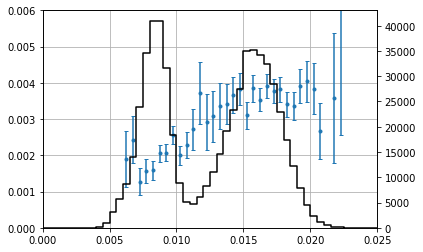

In [32]:
step = 0.0005
edges = np.arange(0, 0.03, step)
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 1 < hist

plt.figure()
plt.errorbar(
    edges[1:][where] + step / 2,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
plt.xlim(0, 0.025)
plt.ylim(0, 0.006)
plt.grid(True)

plt.twinx()
plt.step(edges[:-1], shots, "k")
plt.xlim(0, 0.025)
plt.ylim(0, None)
plt.show()